## saving masks to a nucleus image dataset

In [32]:
import h5py
import pytiff
import numpy as np
import pandas as pd
from skimage.measure import label

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

In [9]:
!ls -lha /mnt/linux-data/codex/preprocessed_data/201021_BreastFFPE_Final/*.tif

-rw-rw-r-- 1 ing ing 120K Nov 12 22:41 /mnt/linux-data/codex/preprocessed_data/201021_BreastFFPE_Final/201021_BreastFFPE_Final_1_tissue.tif
-rw-rw-r-- 1 ing ing  14M Nov 12 22:41 /mnt/linux-data/codex/preprocessed_data/201021_BreastFFPE_Final/201021_BreastFFPE_Final_2_nuclei.tif
-rw-rw-r-- 1 ing ing  35M Nov 12 22:41 /mnt/linux-data/codex/preprocessed_data/201021_BreastFFPE_Final/201021_BreastFFPE_Final_2_stardist.tif


In [31]:
!ls -lha /mnt/linux-data/codex/preprocessed_data/201021_BreastFFPE_Final/*.csv

-rw-rw-r-- 1 ing ing 3.9M Nov 12 22:42 /mnt/linux-data/codex/preprocessed_data/201021_BreastFFPE_Final/201021_BreastFFPE_Final_3_cells.csv


In [11]:
tiff_path = '/mnt/linux-data/codex/preprocessed_data/201021_BreastFFPE_Final/201021_BreastFFPE_Final_2_nuclei.tif'
with pytiff.Tiff(tiff_path, "r") as f:
    img = f.pages[0][:]
print(img.shape)

(7602, 16830)


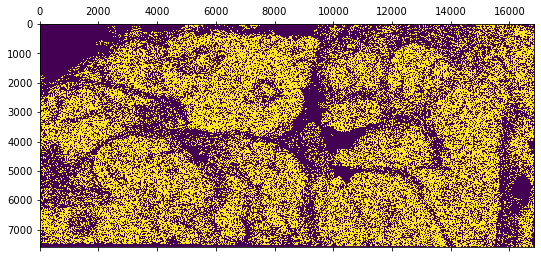

In [16]:
plt.matshow(img)

In [18]:
help(label)

Help on function label in module skimage.measure._label:

label(input, neighbors=None, background=None, return_num=False, connectivity=None)
    Label connected regions of an integer array.
    
    Two pixels are connected when they are neighbors and have the same value.
    In 2D, they can be neighbors either in a 1- or 2-connected sense.
    The value refers to the maximum number of orthogonal hops to consider a
    pixel/voxel a neighbor::
    
      1-connectivity     2-connectivity     diagonal connection close-up
    
           [ ]           [ ]  [ ]  [ ]             [ ]
            |               \  |  /                 |  <- hop 2
      [ ]--[x]--[ ]      [ ]--[x]--[ ]        [x]--[ ]
            |               /  |  \             hop 1
           [ ]           [ ]  [ ]  [ ]
    
    Parameters
    ----------
    input : ndarray of dtype int
        Image to label.
    neighbors : {4, 8}, int, optional
        Whether to use 4- or 8-"connectivity".
        In 3D, 4-"connect

In [20]:
labelimg, n_labels = label(img, neighbors=4, return_num=True)
print(labelimg.shape, n_labels)

<ipython-input-20-42de17974c40>:1: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=4, use connectivity=1
  labelimg, n_labels = label(img, neighbors=4, return_num=True)


(7602, 16830) 152418


In [22]:
!ls tests

dataset.hdf5  test_codexutils__pull_nuclei.ipynb  test_imports.ipynb


In [27]:
!ls -lha weights.h5

-rw-rw-r-- 1 ing ing 113M Nov 15 12:41 weights.h5


In [28]:
h5f = h5py.File("tests/dataset.hdf5", "r+")
print(h5f.keys())
print(h5f['cells'].keys())
print(h5f['meta'].keys())
h5f.close()

<KeysViewHDF5 ['cells', 'meta']>
<KeysViewHDF5 ['C1q', 'CD103', 'CD11c', 'CD134', 'CD138', 'CD20', 'CD31', 'CD3e', 'CD4', 'CD40', 'CD40LG', 'CD45', 'CD45RA', 'CD45RO', 'CD64', 'CD68', 'CD69', 'CD8', 'CD80', 'CD89', 'CXCL13', 'CXCR5', 'DAPI', 'FOXP3', 'GZMB', 'HLA-DR', 'IL7R', 'IgA', 'IgG', 'IgM', 'Ki-67', 'LAG3', 'OX40L', 'PD-1', 'PD-L1', 'PDGFRb', 'PNaD', 'PanCytoK', 'TIM3', 'aSMA']>
<KeysViewHDF5 ['Cell_IDs', 'channel_names']>


In [38]:
use_cells = [c.decode('UTF-8') for c in h5f['meta/Cell_IDs'][:]]
print(len(use_cells))

146791


In [39]:
cell_table = '/mnt/linux-data/codex/preprocessed_data/201021_BreastFFPE_Final/201021_BreastFFPE_Final_3_cells.csv'
cell_df = pd.read_csv(cell_table, index_col=0, header=0)
cell_df = cell_df.loc[use_cells]
cell_df

,X,Y,Size
cell_ID,,,
cell_132,34,6733,1711
cell_180,36,7073,1168
cell_198,33,3993,606
cell_201,38,7215,1045
cell_212,37,6361,938
...,...,...,...
cell_152281,16797,5665,267
cell_152285,16797,5629,304
cell_152305,16797,4907,186


In [40]:
coords = np.array(cell_df.loc[:, ['X', 'Y']])
print(coords.shape)

(146791, 2)


In [61]:
from tqdm.auto import tqdm

In [65]:
size = 64
sizeh = int(size/2)

c = coords[0]
masks = []
for c in tqdm(coords):
    x, y = c
    bbox = [y-sizeh, y+sizeh, x-sizeh, x+sizeh]
    subimg = labelimg[bbox[0]:bbox[1], bbox[2]:bbox[3]]

    l = subimg[sizeh, sizeh]

    #plt.matshow(subimg==l)
    masks.append(subimg==l)
    
masks = np.stack(masks, axis=0)
print(masks.shape)


(146791, 64, 64)


(9394624, 64)
